# Calgary Stampeders - Event Propensity MVP
* StellarAlgo Data Science
* Nakisa Rad & Ryan Kazmerik
* May 26, 2022

## Hypothesis
We think that using our Stellar Event Propensity model, we can produce a list of fans that have higher probability to purchase a individual ticket to a game based on their previous purchasing and engagement behaviour.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [117]:
import boto3
import getpass
import pyodbc
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### To connect to RedShift, we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [118]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

TFFV-VBBL
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


### Now we can create a session and client to RedShift, and create a new connection using Psycopg2:

In [119]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'prod-app'
DBNAME = 'stlrcfl'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: prod-app stlrcfl


### Let's connect to Redshift and run a stored proc to get our dataset:

In [120]:
cur = conn.cursor()
cur.execute(f"CALL ds.geteventpropensitytrainingdata(35, 2010, 2022, 'rkcursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('rkcursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysout              18028 non-null  object        
 1   mindaysout           18028 non-null  int64         
 2   maxdaysout           11282 non-null  float64       
 3   dimcustomermasterid  18028 non-null  int64         
 4   recent_openrate      18028 non-null  float64       
 5   recent_clickrate     18028 non-null  float64       
 6   eventdate            18028 non-null  datetime64[ns]
 7   eventname            18028 non-null  object        
 8   inmarket             16359 non-null  object        
 9   distancetovenue      16359 non-null  float64       
 10  tenure               18028 non-null  int64         
 11  did_purchase         18028 non-null  int64         
 12  events_purchased     18028 non-null  int64         
 13  frequency_opponent   18028 non-

In [122]:
# choose the features for the stellar base retention model
features = [
                "daysout",
                #"mindaysout",
                #"maxdaysout",
                "dimcustomermasterid",
                "recent_openrate",
                "recent_clickrate",
                "eventdate",
                #"eventname",
                "inmarket",
                "distancetovenue",
                "tenure",
                "did_purchase",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventday",
                "frequency_eventtime"
                #"count_merchowned"
]

# copy your main dataframe
df_dataset = df

#creating the training and evaluation dataframe
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (15324, 13)
Unseen Data For Predictions: (2704, 13)



### Now we can model the data using a binary classification prediction for the did_purchase field to see how likely a customer is to re-purchase.

In [123]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimcustomermasterid"],
    silent=True,
    verbose=False,
    numeric_features=[
        
                #"mindaysout",
                #"maxdaysout",
                "recent_openrate",
                "recent_clickrate",
                "distancetovenue",
                "tenure",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventday",
                "frequency_eventtime"
                #"count_merchowned"
    ]
);

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.3.5
INFO:logs:Initializing setup()
INFO:logs:setup(target=did_purchase, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}, train_size=0.85, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, or

In [124]:
model_matrix = compare_models(
    fold=10,
    include=[ "lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8187,0.9089,0.8192,0.8169,0.8180,0.6375,0.6376,0.0700


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7266, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:compare_models() succesfully completed......................................


In [125]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8273,0.9151,0.8210,0.8300,0.8254,0.6546,0.6547
1,0.8181,0.9130,0.8194,0.8157,0.8176,0.6362,0.6362
2,0.8342,0.9088,0.8349,0.8323,0.8336,0.6685,0.6685
3,0.8219,0.9171,0.8086,0.8291,0.8188,0.6438,0.6440
4,0.8043,0.8949,0.7963,0.8075,0.8019,0.6086,0.6086
5,0.8141,0.9067,0.8068,0.8169,0.8118,0.6282,0.6283
6,0.8072,0.9058,0.8068,0.8056,0.8062,0.6144,0.6144
7,0.8172,0.9095,0.8192,0.8141,0.8166,0.6344,0.6344
8,0.8164,0.9051,0.8470,0.7965,0.8210,0.6330,0.6343
9,0.8264,0.9131,0.8318,0.8216,0.8267,0.6529,0.6529


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7266, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................
INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_j

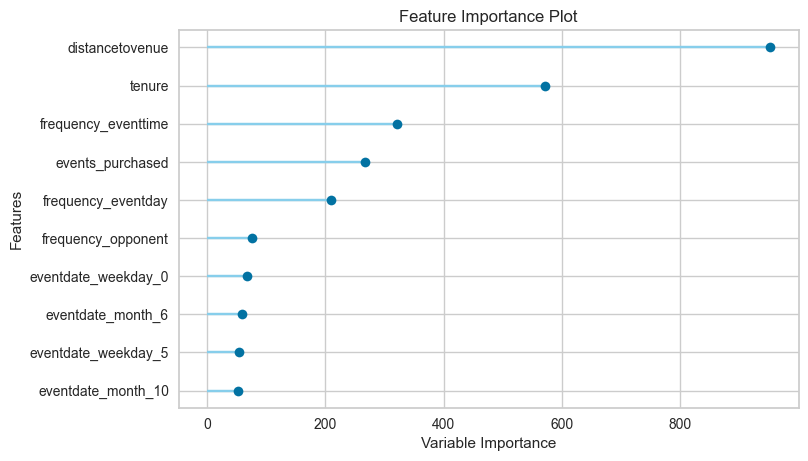

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [126]:
plot_model(final_model, plot='feature')

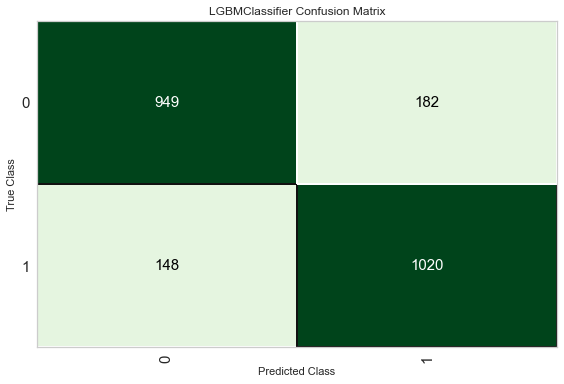

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [127]:
plot_model(final_model, plot='confusion_matrix')

### First we need to call the stored procedure, which will create a named cursor - then we can query the results produced by the stored proc using that named cursor to create scoring dataframe:

In [128]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'prod-app'
DBNAME = 'stlrcfl'

creds2 = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn2 = psycopg2.connect(
    host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds2['DbUser'],
    password = creds2['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: prod-app stlrcfl


In [129]:
# create a list of games dates 
game_dates= ['2022-06-09','2022-06-25','2022-07-30','2022-08-13','2022-09-05','2022-09-17','2022-10-01','2022-10-14','2022-10-29']

predictions =[]
for game_date in game_dates:
    
    cur2 = conn2.cursor()
    cur2.execute(f"CALL ds.geteventpropensityscoringdata(35, '{game_date}', 'result')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn2.cursor('result')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df_scoring = pd.DataFrame(data=data, columns=cols)
    df_scoring = df_scoring.fillna(0)
    #print(df_scoring)
    
    # get predictions from the model for each game
    new_predictions = predict_model(final_model, data=df_scoring, raw_score=True)
    predictions.append(new_predictions)
    
    conn2.commit()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7266, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=False, raw_score=True, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
      

In [130]:
#predictions

In [131]:
for df_game in predictions:
    print(str(df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")) + '\n' + str(df_game["Score_1"].value_counts(bins=[0, 0.5, 0.8, 1.0])))

06-09-2022
(0.8, 1.0]       35611
(0.5, 0.8]       32778
(-0.001, 0.5]    17811
Name: Score_1, dtype: int64
06-25-2022
(0.8, 1.0]       49816
(0.5, 0.8]       27796
(-0.001, 0.5]     8588
Name: Score_1, dtype: int64
07-30-2022
(-0.001, 0.5]    41761
(0.5, 0.8]       29000
(0.8, 1.0]       15439
Name: Score_1, dtype: int64
08-13-2022
(0.8, 1.0]       38147
(0.5, 0.8]       30443
(-0.001, 0.5]    17610
Name: Score_1, dtype: int64
09-05-2022
(0.5, 0.8]       36865
(0.8, 1.0]       28216
(-0.001, 0.5]    21119
Name: Score_1, dtype: int64
09-17-2022
(0.8, 1.0]       35621
(0.5, 0.8]       28600
(-0.001, 0.5]    21979
Name: Score_1, dtype: int64
10-01-2022
(-0.001, 0.5]    64494
(0.5, 0.8]       19469
(0.8, 1.0]        2237
Name: Score_1, dtype: int64
10-14-2022
(0.8, 1.0]       54318
(0.5, 0.8]       16487
(-0.001, 0.5]    15395
Name: Score_1, dtype: int64
10-29-2022
(0.8, 1.0]       60794
(0.5, 0.8]       14995
(-0.001, 0.5]    10411
Name: Score_1, dtype: int64


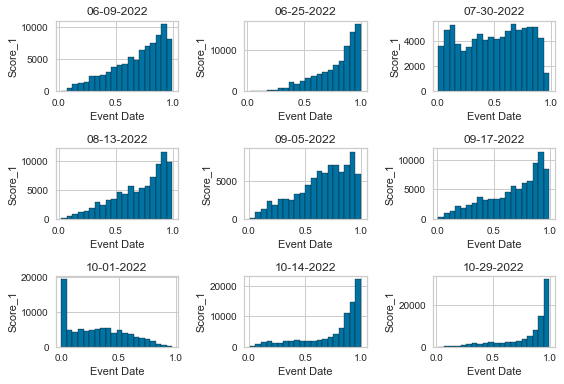

In [132]:
for idx, df_game in enumerate(predictions):
    
    plt.subplot(3, 3, idx+1)
    
    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    
    plt.title(event_date, fontsize = 12)
    plt.xlabel("Event Date")
    plt.ylabel("Score_1")
    plt.hist(df_game['Score_1'], bins= 20, edgecolor = "black")
plt.tight_layout()
plt.show()

In [133]:
for df_game in predictions:
    print(df_game["eventdate"].value_counts().sort_index(ascending=False))

2022-06-09    86200
Name: eventdate, dtype: int64
2022-06-25    86200
Name: eventdate, dtype: int64
2022-07-30    86200
Name: eventdate, dtype: int64
2022-08-13    86200
Name: eventdate, dtype: int64
2022-09-05    86200
Name: eventdate, dtype: int64
2022-09-17    86200
Name: eventdate, dtype: int64
2022-10-01    86200
Name: eventdate, dtype: int64
2022-10-14    86200
Name: eventdate, dtype: int64
2022-10-29    86200
Name: eventdate, dtype: int64


### Save the results in for each game in a csv file

In [134]:
for df_game in predictions:

    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"prod_results_redshift/stamps_ep_scores_{event_date}.csv", index=False)

## Observations

1. How accurate was this model? 
* The accuracy is 80% 

2. How many fans scored over 0.80 for the 2022 season?
* 06-09-2022 : 35,923 out of 86200
* 06-25-2022 : 54,642 out of 86200
* 07-30-2022 : 42,361 out of 86200
* 08-13-2022 : 50,992 out of 86200
* 09-05-2022 : 36,389 out of 86200
* 09-17-2022 : 40,720 out of 86200
* 10-01-2022 : 75,649 out of 86200
* 10-14-2022 : 44,672 out of 86200
* 10-29-2022 : 58,814 out of 86200

3. What were the most important features in making a correct prediction?
* distancetovenue, tenure , frequency_eventTime are top 3 important features which makes sense.


Current training dataset size of 2021 data: 16928
Current training dataset size of 2022 data: 16928


## Conclusion

Based on our observations above we reccomend using this event propensity model because we get enough number of buyers that have score above 80% for each game that can be useful for Stamps.